## A Basic Capacity Expansion Model

- Reference: https://github.com/Power-Systems-Optimization-Course/power-systems-optimization/blob/master/Notebooks/03-Basic-Capacity-Expansion.ipynb

In [1]:
# You need to instal both Pyomo and glpk package before running the code 

from pyomo.environ import *
import numpy as np
import math
import pandas   as pd
from pandas import Series, DataFrame

In [14]:
generators = pd.read_csv("expansion_data/generators_for_expansion.csv")
demand = pd.read_csv("expansion_data/demand_for_expansion.csv")


In [5]:
generators

,G,Description,Capex,FixedOM,VarOM,HeatRate,FuelCost,WACC,AssetLife,CRF,Annuity,FixedCost,VarCost
0,Geo,Geothermal,7500000,130000,0,28.4,0,0.040,30,0.0578,433500,563500,0.0
1,Coal,Supercritical Coal,2600000,120000,8,8.1,2,0.040,30,0.0578,150280,270280,24.2
2,CCGT,Natural gas CCGT,1000000,28000,2,6.4,4,0.035,30,0.0544,54400,82400,27.6
3,CT,Natural gas CT,770000,21000,5,9.7,4,0.035,30,0.0544,41888,62888,43.8
4,Wind,Onshore wind,1000000,40000,0,1.0,0,0.030,30,0.0510,51000,91000,0.0
5,Solar,Tracking solar PV,750000,15000,0,1.0,0,0.025,30,0.0478,35850,50850,0.0


In [7]:
demand

,Hour,Demand
0,1,2274
1,2,2581
2,3,2576
3,4,2482
4,5,2396
...,...,...
8755,8756,2708
8756,8757,2646
8757,8758,2538
8758,8759,2195


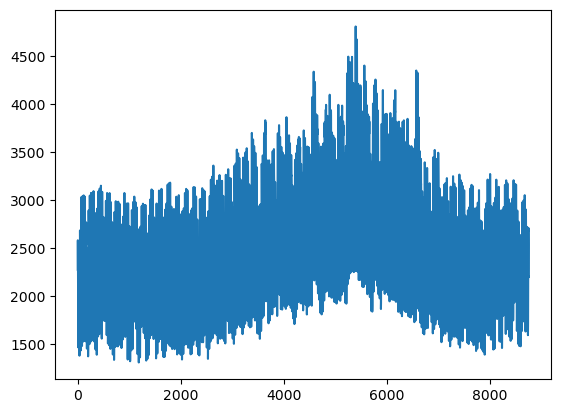

In [12]:
import matplotlib.pyplot as plt

plt.plot(demand.Demand)

In [16]:
demand_

,Hour,Demand
5398,5399,4813
5399,5400,4784
5397,5398,4745
5422,5423,4677
5400,5401,4670
...,...,...
705,706,1333
1330,1331,1326
1186,1187,1321
1017,1018,1319


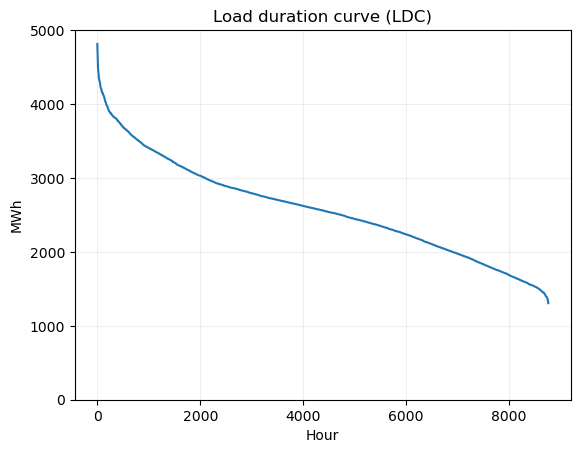

In [20]:
demand_ = demand.sort_values(by='Demand', ascending=False)
demand_ = demand_.reset_index(drop=True)

plt.plot(demand_['Demand'])
plt.ylim(0, 5000)
plt.title('Load duration curve (LDC)')
plt.xlabel('Hour')
plt.ylabel('MWh')
plt.grid(alpha=0.2)
plt.show()

In [23]:
demand_['Demand']

0       4813
1       4784
2       4745
3       4677
4       4670
        ... 
8755    1333
8756    1326
8757    1321
8758    1319
8759    1306
Name: Demand, Length: 8760, dtype: int64

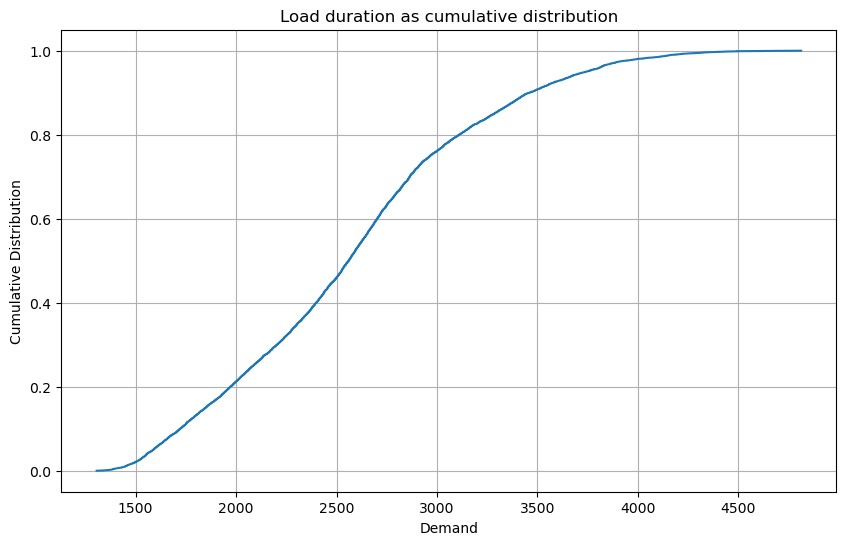

In [25]:
# Create an array representing the cumulative distribution
cumulative_distribution = np.linspace(0.,1.,len(demand))
demand_ = demand.sort_values(by='Demand')
demand_ = demand_.reset_index(drop=True)
plt.figure(figsize=(10, 6))
plt.plot(demand_['Demand'], cumulative_distribution)
plt.title('Load duration as cumulative distribution')
plt.xlabel('Demand')
plt.ylabel('Cumulative Distribution')
plt.grid(True)
plt.show()

In [31]:
generators

,G,Description,Capex,FixedOM,VarOM,HeatRate,FuelCost,WACC,AssetLife,CRF,Annuity,FixedCost,VarCost
0,Geo,Geothermal,7500000,130000,0,28.4,0,0.040,30,0.0578,433500,563500,0.0
1,Coal,Supercritical Coal,2600000,120000,8,8.1,2,0.040,30,0.0578,150280,270280,24.2
2,CCGT,Natural gas CCGT,1000000,28000,2,6.4,4,0.035,30,0.0544,54400,82400,27.6
3,CT,Natural gas CT,770000,21000,5,9.7,4,0.035,30,0.0544,41888,62888,43.8
4,Wind,Onshore wind,1000000,40000,0,1.0,0,0.030,30,0.0510,51000,91000,0.0
5,Solar,Tracking solar PV,750000,15000,0,1.0,0,0.025,30,0.0478,35850,50850,0.0


In [57]:
# Create a concrete model in Pyomo 
model = ConcreteModel()

# penalty for non-served energy 
NSECost = 9000


# The set of generators from the generators DataFrame

model.G  = Set(initialize=RangeSet(0,generators.shape[0] -3), doc='set of generators') 

# The set of hours in the demand DataFrame
model.H = Set(initialize=RangeSet(0,len(demand.Hour)-1), doc='set of time')  

# Generating capacity built (MW)
model.CAP=Var(model.G,domain=NonNegativeReals)
# Generation in each hour (MWh)

model.GEN=Var(model.G,model.H,domain=NonNegativeReals)
 # Non-served energy in each hour (MWh)
model.NSE=Var(model.H,domain=NonNegativeReals)

#cDemandBalance (eq. 11)
def cDemandBalance_(model,h):
    return(sum(model.GEN[i,h] for i in model.G) + model.NSE[h] == demand.Demand[h])
model.cDemandBalance=Constraint(model.H,rule=cDemandBalance_)


#cCapacity (eq. 12)
def cCapacity_(model,g,h):
    return(model.GEN[g,h] <= model.CAP[g] )
model.cCapacity=Constraint(model.G,model.H,rule=cCapacity_)

# ---------------Objective Function-------------------
def obj_rule(model):
    fixed_cost_=sum(generators["FixedCost"][i] * model.CAP[i] for i in model.G)
    variable_cost_=sum(generators["VarCost"][i] * model.GEN[i,h] for i in model.G for h in model.H)
    not_supplied_cost=sum(NSECost * model.NSE[h] for h in model.H)
    return (fixed_cost_+variable_cost_+not_supplied_cost)
model.of=Objective(rule=obj_rule,sense=minimize)

In [58]:
# This cell runs the code using "glpk" package. Whether the model is feasible or not is printed afterward
solver = SolverFactory('glpk')     
#solver.options['thread']=4

# solver.options['mipgap']=1e-1


results = solver.solve(model, tee=True)   
model.solutions.load_from(results)  
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  results.solver.status)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\SAEED~1.MIS\AppData\Local\Temp\tmpix4zozt7.glpk.raw --wglp
 C:\Users\SAEED~1.MIS\AppData\Local\Temp\tmpbwubey96.glpk.glp --cpxlp C:\Users\SAEED~1.MIS\AppData\Local\Temp\tmp1kmv6el8.pyomo.lp
Reading problem data from 'C:\Users\SAEED~1.MIS\AppData\Local\Temp\tmp1kmv6el8.pyomo.lp'...
43801 rows, 43805 columns, 113881 non-zeros
324140 lines were read
Writing problem data to 'C:\Users\SAEED~1.MIS\AppData\Local\Temp\tmpbwubey96.glpk.glp'...
280335 lines were written
GLPK Simplex Optimizer 5.0
43801 rows, 43805 columns, 113881 non-zeros
Preprocessing...
43800 rows, 35044 columns, 105120 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 43800
*     0: obj =   2.031110730e+11 inf =   0.000e+00 (35040)
*  7617: obj =   4.361604550e+10 inf =   0.000e+00 (7855) 7
* 14491: obj

In [95]:
# Initialize an empty DataFrame
results = pd.DataFrame(columns=['Resource', 'MW', 'Percent_MW', 'GWh', 'Percent_GWh'])

# Record generation capacity and energy results
for i in model.G:
    generation = value(sum(model.GEN[i,h] for h in model.H))
    MWh_share = generation/sum(demand.Demand)*100
    cap_share = value(model.CAP[i])/np.max(demand.Demand)*100
    results = results.append({
        'Resource': generators.G[i], 
        'MW': value(model.CAP[i]),
        'Percent_MW': cap_share,
        'GWh': generation/1000,
        'Percent_GWh': MWh_share
    }, ignore_index=True)
    
# Calculate how much non-served energy there was and add to results
  # The maximum MW of non-served energy is the difference 
  # between peak demand and total installed generation capacity
NSE_MW = 0 
for h in model.H:
    initial= value(model.NSE[h]) 
    if initial > NSE_MW:
        NSE_MW=initial   
#   The total MWh of non-served energy is the difference between
#   total demand and total generation
NSE_MWh = value(sum(model.NSE[h] for h in model.H))
#   Add or "push" a new row of data to the end of the results DataFrame

results = results.append({
        'Resource': "NSE", 
        'MW': NSE_MW,
        'Percent_MW': NSE_MW/(np.max(demand.Demand)*100),
        'GWh': NSE_MW/1000,
        'Percent_GWh': NSE_MWh/sum(demand.Demand)*100
    },ignore_index=True)          

C:\Users\saeed.misaghian\AppData\Local\Temp\ipykernel_17816\529242414.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\saeed.misaghian\AppData\Local\Temp\ipykernel_17816\529242414.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\saeed.misaghian\AppData\Local\Temp\ipykernel_17816\529242414.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\saeed.misaghian\AppData\Local\Temp\ipykernel_17816\529242414.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\saeed.misaghian\AppData\Local\Temp\ipyk